### Building Fine-tuned VGG16 model

To overcome this overfitting problem, we can fine tune a pre-trained model to classify images. Most famouse pre-trained model for image classificaiton is called `VGG16` which came out as a winner of 2014 ImageNet competition classifying 1000 image classes. `cat` and `dog` were amoung them.

In data preprocessing phase we used a `preprocessing_function` that `VGG16` used. This is nothing but substracting the mean RGB of training set from each pixel.

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
%matplotlib inline

### Preprocess the data

In [17]:
train_path = 'data/dogs-vs-cats/train'
valid_path = 'data/dogs-vs-cats/valid'
test_path = 'data/dogs-vs-cats/test'
train_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory = train_path, target_size = (224,224), classes = ['cat', 'dog'], batch_size = 10)
valid_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory = valid_path, target_size = (224,224), classes = ['cat', 'dog'], batch_size = 10)
test_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory = test_path, target_size = (224,224), classes = ['cat', 'dog'], batch_size = 10, shuffle = False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


### Download the VGG16 model

In [5]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [6]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Fine-tune the VGG16 model
As this `VGG16` model is heavily dense, our objective of the fine-tune is to remove the last layer and train the model in to over cat-vs-dog dataset to have only 2 units.

In [7]:
type(vgg16_model)

keras.engine.functional.Functional

`vgg16_model` is functional type model. To convert it to a sequential model, we iterate through all layers except the last one and add the weights to a new sequential model.

In [8]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

Now with these parameters we can train out dataset to get only two outputs. When we go through the traing process with this model, we need to freeze all the trainable parameters by seting `layer.trainable` to `False`.m

In [11]:
for layer in model.layers:
    layer.trainable = False

Lets add the output layer which will be the only trainable layer in this model.

In [12]:
model.add(Dense(units = 2, activation = 'softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

### Train the fine-tuned VGG16 model

In [14]:
model.compile(optimizer = Adam(learning_rate = 0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [18]:
model.fit(x = train_batches, 
          validation_data = valid_batches, 
          epochs = 5, 
          verbose = 2)

Epoch 1/5
100/100 - 425s - loss: 0.3105 - accuracy: 0.8670 - val_loss: 0.1086 - val_accuracy: 0.9550 - 425s/epoch - 4s/step
Epoch 2/5
100/100 - 842s - loss: 0.0843 - accuracy: 0.9750 - val_loss: 0.0906 - val_accuracy: 0.9550 - 842s/epoch - 8s/step
Epoch 3/5
100/100 - 442s - loss: 0.0617 - accuracy: 0.9800 - val_loss: 0.0767 - val_accuracy: 0.9700 - 442s/epoch - 4s/step
Epoch 4/5
100/100 - 449s - loss: 0.0467 - accuracy: 0.9880 - val_loss: 0.0818 - val_accuracy: 0.9650 - 449s/epoch - 4s/step
Epoch 5/5
100/100 - 445s - loss: 0.0375 - accuracy: 0.9930 - val_loss: 0.0772 - val_accuracy: 0.9650 - 445s/epoch - 4s/step


### Predicting with fine-tuned VGG16 model

In [19]:
predictions = model.predict(x = test_batches, verbose = 0)
predictions = np.round(predictions)

In [20]:
cm = confusion_matrix(y_true = test_batches.classes, 
                      y_pred = np.argmax(predictions, axis = -1))

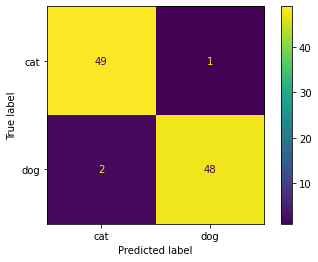

In [21]:
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = test_batches.class_indices)
disp.plot()
plt.show()